In [36]:
import torch
from model.transformer import TransformerTimeSeriesModel

import pandas as pd



In [37]:
# Step 2: Initialize and load Transformer model
input_size = 8
d_model = 128
nhead = 4
num_layers = 6
output_size = 30
model_path = "../models/Transformer_2d3da52c42714d09966f4533c87c490c.pth"

model = TransformerTimeSeriesModel(input_size, d_model, nhead, num_layers, output_size)
model.load_state_dict(torch.load(model_path))
model.eval()

print("Model loaded successfully")

Model loaded successfully


/var/folders/_l/lg0zz1ln2_z8ct4p275jp5880000gn/T/ipykernel_51573/139128765.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

In [38]:
# Step 3: Perform predictions on historical data
from data_processing.prepare_data import prepare_backtest_input

price_data, feature_data, date_data = prepare_backtest_input("../data/processed/merged_data.csv")

선택된 데이터 기간: 2023-05-03 00:00:00 ~ 2024-10-14 00:00:00


In [ ]:
# Step 5: Run backtest
from backtest.agent import BacktestAgent

initial_balance = price_data[0]

# 백테스트 실행
n_steps = 30  # 시퀀스 길이
agent = BacktestAgent(
    model=model,
    price_data=price_data,
    feature_data=feature_data,
    date_data=date_data,
    n_steps=n_steps,
    initial_balance=initial_balance,
    transaction_cost=0.001,
    signal_threshold=0.03,
    risk_tolerance=0.3,
)

agent.run()

Backtest completed.


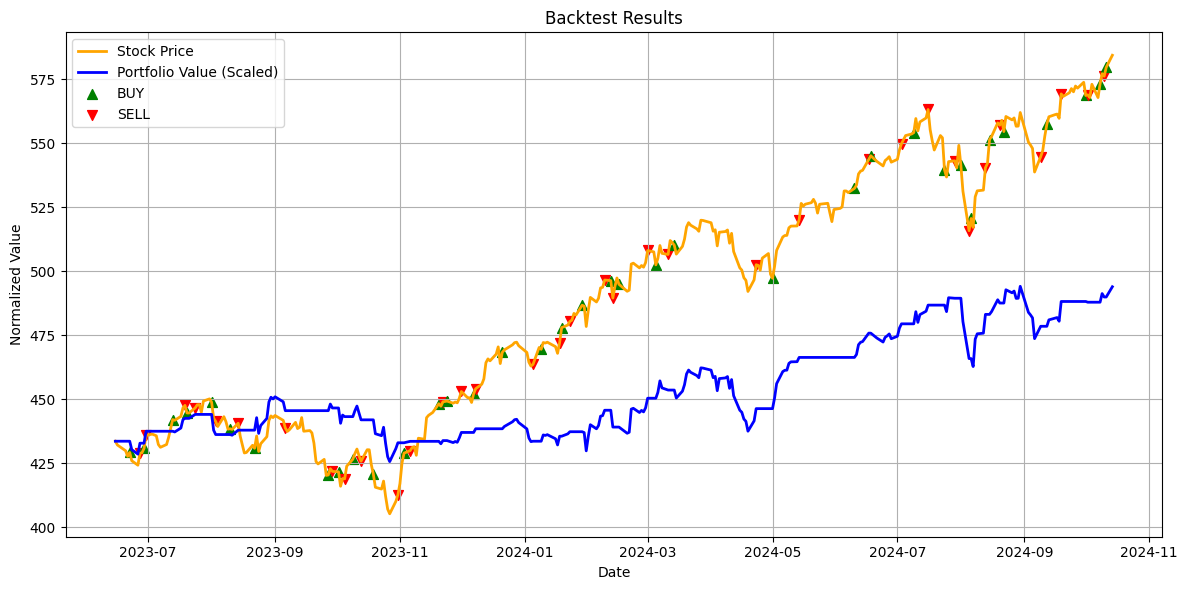

In [40]:
agent.show_plot()